In [50]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [51]:
split_data = ["LCK 2021 Spring.csv", "LCK 2021 Summer.csv", "LCK 2022 Spring.csv", "LCK 2022 Summer.csv"]
mvp_data = ['2021_spring.csv', '2021_summer.csv', '2022_spring.csv', '2022_summer.csv']

splits = []

In [52]:
temp1 = pd.read_csv('2021_summer.csv')
temp2 = pd.read_csv("LCK 2021 Summer.csv")
temp1.shape
for index, row in temp2.iterrows():
    if(index<=61):
        print(index, row['Player'])#, temp1.loc[index, 'MVP'])

0 5kid
1 BAO
2 Bdd
3 BeryL
4 Blank
5 Burdol
6 Canna
7 Canyon
8 Canyon
9 Chieftain
10 Chovy
11 Clid
12 Croco
13 Cuzz
14 Deft
15 Delight
16 deokdam
17 Destroy
18 Doran
19 Dove
20 Dread
21 DuDu
22 Effort
23 Faker
24 FATE
25 Fly
26 Ghost
27 gideon
28 Gori
29 Gumayusi
30 Harp
31 Hena
32 HOYA
33 Jett
34 Jun
35 Kellin
36 Keria
37 Khan
38 Kiin
39 Kingen
40 Kingen
41 Lava
42 Lehends
43 Leo
44 Life
45 Malrang
46 Mir
47 Morgan
48 Noah
49 Oner
50 Peanut
51 Pleata
52 Prince
53 Pyosik
54 Quad
55 Rascal
56 Rich
57 Ruler
58 ShowMaker
59 ShowMaker
60 Summit
61 Taeyoon


In [53]:
for index in range(0, 4):
    split = pd.read_csv(split_data[index])
    split = split[split['GP'] >= 10]
    split['Year'] = str(split_data[index][4:8])
    split['Season'] = split_data[index][9:15]
    
    #special case where ShowMaker (the absolute monster) played ADC (10 games) (Ghost got benched)
    # and many more Mid in DWG for '21 Spring
    #his Pog points are counted the same, but he is represented as two separate roles
    #we take the decision to remove ShowMaker ADC from the list
    if split['Year'].iloc[0] == '2021' and split['Season'].iloc[0] == 'Summer':
        print(split.shape)
        split = split[~((split['Player'] == 'ShowMaker') & (split['Pos'] == 'ADC'))]
        split = split[~((split['Player'] == 'Canyon') & (split['Pos'] == 'Middle'))]
        print(split.shape)
        
    exclude = ['Player', 'Team', 'Pos', 'Year', 'Season']
    incldue = [col for col in split.columns if col not in exclude]
    for cols in incldue:
        for idx, val in split[cols].items():
            if str(val).endswith("%"):
                split.at[idx, cols] = str(val.strip("%"))

    split[incldue] = split[incldue].astype('float64')
    split = split.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvp_cur = pd.read_csv(mvp_data[index])
    mvp_cur = mvp_cur.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvplist = mvp_cur['MVP'].reset_index(drop=True)
    split = split.reset_index(drop=True)
    split['MVP'] = mvplist
    splits.append(split)
    

(63, 30)
(61, 30)


In [54]:
for index, row in splits[1].iterrows():
    print(index, row['Player'], row['MVP'])

0 Pleata 0.0
1 Jett 100.0
2 Kingen 400.0
3 Pyosik 200.0
4 BAO 0.0
5 yoHan 100.0
6 Morgan 0.0
7 Jun 100.0
8 Zzus 0.0
9 Quad 0.0
10 Summit 800.0
11 Taeyoon 0.0
12 Vsta 100.0
13 Effort 700.0
14 DuDu 0.0
15 HOYA 400.0
16 Harp 0.0
17 BeryL 100.0
18 Rich 300.0
19 Khan 800.0
20 Life 300.0
21 Delight 100.0
22 Willer 100.0
23 Noah 100.0
24 Doran 700.0
25 Fly 500.0
26 Deft 400.0
27 Gori 1100.0
28 Keria 100.0
29 Croco 500.0
30 Kiin 900.0
31 Kellin 0.0
32 Canna 500.0
33 Faker 900.0
34 Hena 100.0
35 UmTi 400.0
36 Lehends 100.0
37 Cuzz 200.0
38 Oner 300.0
39 Lava 900.0
40 Rascal 500.0
41 Dove 700.0
42 Mir 100.0
43 Chovy 900.0
44 Blank 500.0
45 FATE 400.0
46 Prince 200.0
47 Dread 600.0
48 Clid 500.0
49 Canyon 1000.0
50 Ghost 100.0
51 Bdd 700.0
52 Leo 400.0
53 Peanut 600.0
54 deokdam 700.0
55 Gumayusi 200.0
56 5kid 0.0
57 Ruler 500.0
58 Malrang 200.0
59 ShowMaker 700.0
60 Teddy 300.0


In [55]:
from sklearn.preprocessing import MinMaxScaler
def scale_split(df):
    scaler = MinMaxScaler()
    numerical_columns = df.select_dtypes(include='number').columns
    #print(numerical_columns)
    scaled_df = df.copy()
    
    scaled_df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    non_numeric_columns = df.select_dtypes(exclude='number').columns
    #print(non_numeric_columns)
    scaled_df[non_numeric_columns] = df[non_numeric_columns]
    
    return scaled_df

In [56]:
scaled_splits = []
for split in splits:
    scaled = scale_split(split)
    scaled_splits.append(scaled)
whole_set = pd.concat(scaled_splits, ignore_index=True)

In [57]:
narows = whole_set[whole_set['MVP'].isnull()]
print(narows)

Empty DataFrame
Columns: [Player, Team, Pos, GP, W%, CTR%, K, D, A, KDA, KP, KS%, DTH%, FB%, GD10, XPD10, CSD10, CSPM, CS%P15, DPM, DMG%, D%P15, EGPM, GOLD%, STL, WPM, CWPM, WCPM, Year, Season, MVP]
Index: []

[0 rows x 31 columns]


In [58]:
#whole_set[['Player', 'MVP']].sort_values(by='MVP', ascending=False).head(5)
whole_set = whole_set.dropna(axis=1)
whole_set_vals = whole_set.select_dtypes(include='number')
whole_set_vals = whole_set_vals.drop(['GP', 'MVP'], axis=1)
whole_set_labels = whole_set.select_dtypes(exclude='number')
whole_set_labels = pd.concat([whole_set_labels, whole_set[['GP', 'MVP']]], axis=1)

# drop the columns 
# games played (represented as 'GP') (!= experience. More games played = more chances to receive MVP)
# MVP (represented as 'MVP') (What we want to use a ranking/class/predictor)
# from the list whole_set
role_sets = []

In [59]:
positions = list(set(whole_set['Pos']))
for position in positions:
    role_sets.append(whole_set[whole_set['Pos'] == position])

In [61]:
role_sets[positions.index("ADC")].sort_values(by='KDA', ascending=False).head()

,Player,Team,Pos,GP,W%,CTR%,K,D,A,KDA,...,DPM,DMG%,EGPM,GOLD%,WPM,CWPM,WCPM,Year,Season,MVP
119,Teddy,T1,ADC,0.236842,0.685185,0.323944,0.312849,0.081481,0.196262,1.000000,...,0.942553,0.897638,0.875000,0.86802,0.377483,0.157895,0.7750,2021,Summer,0.272727
224,Ruler,Gen.G,ADC,0.812500,1.000000,0.452381,1.000000,0.177966,0.419355,1.000000,...,1.000000,0.965517,0.988506,0.85782,0.209877,0.292683,1.0000,2022,Summer,1.000000
56,Teddy,T1,ADC,0.351351,0.940000,0.716981,0.527174,0.179688,0.324022,0.791667,...,0.975560,0.879167,0.987395,0.89372,0.279762,0.166667,0.5000,2021,Spring,0.400000
116,Ruler,Gen.G,ADC,0.947368,0.796296,0.394366,1.000000,0.422222,0.501558,0.787234,...,1.000000,1.000000,1.000000,1.00000,0.284768,0.210526,1.0000,2021,Summer,0.454545
55,Ghost,Dplus KIA,ADC,0.891892,1.000000,0.528302,1.000000,0.414062,0.544693,0.770833,...,0.790224,0.675000,0.945378,0.84058,0.291667,0.250000,0.4375,2021,Spring,0.400000


In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

predicted_labels = []
for role in positions:
    labels = []
    silhouettes = []
    max_silhouette = -1
    max_silhouette_cluster = None
    for num in range(2, 10):
        my_set = role_sets[positions.index(role)]
        my_set_vals = my_set.select_dtypes(include='number')
        my_set_labels = my_set.drop(my_set.select_dtypes(include='number').columns, axis=1)
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(my_set_vals)
        labels.append(kmeans.labels_)
        silhouette_avg = silhouette_score(my_set_vals, labels[num-2])
        #print("Silhouette score for role", role , " at clusters", num, ": ", silhouette_avg)
        silhouettes.append(silhouette_avg)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            max_silhouette_cluster = kmeans.labels_
    print("Max silhouette score for role", role, "at clusters", silhouettes.index(max_silhouette) + 2, ": ", max_silhouette)
    predicted_labels.append(max_silhouette_cluster)
    

Max silhouette score for role ADC at clusters 2 :  0.22262706984116445
Max silhouette score for role Top at clusters 2 :  0.21576288828099424
Max silhouette score for role Jungle at clusters 2 :  0.25175502903582
Max silhouette score for role Support at clusters 2 :  0.2859398395975212
Max silhouette score for role Middle at clusters 2 :  0.24334359547947007


Silhouettes scores are less than 0.3 across the board, suggesting that the available data is not enough to classify each role into different playstyles, or that there is no particular difference between player playstyles

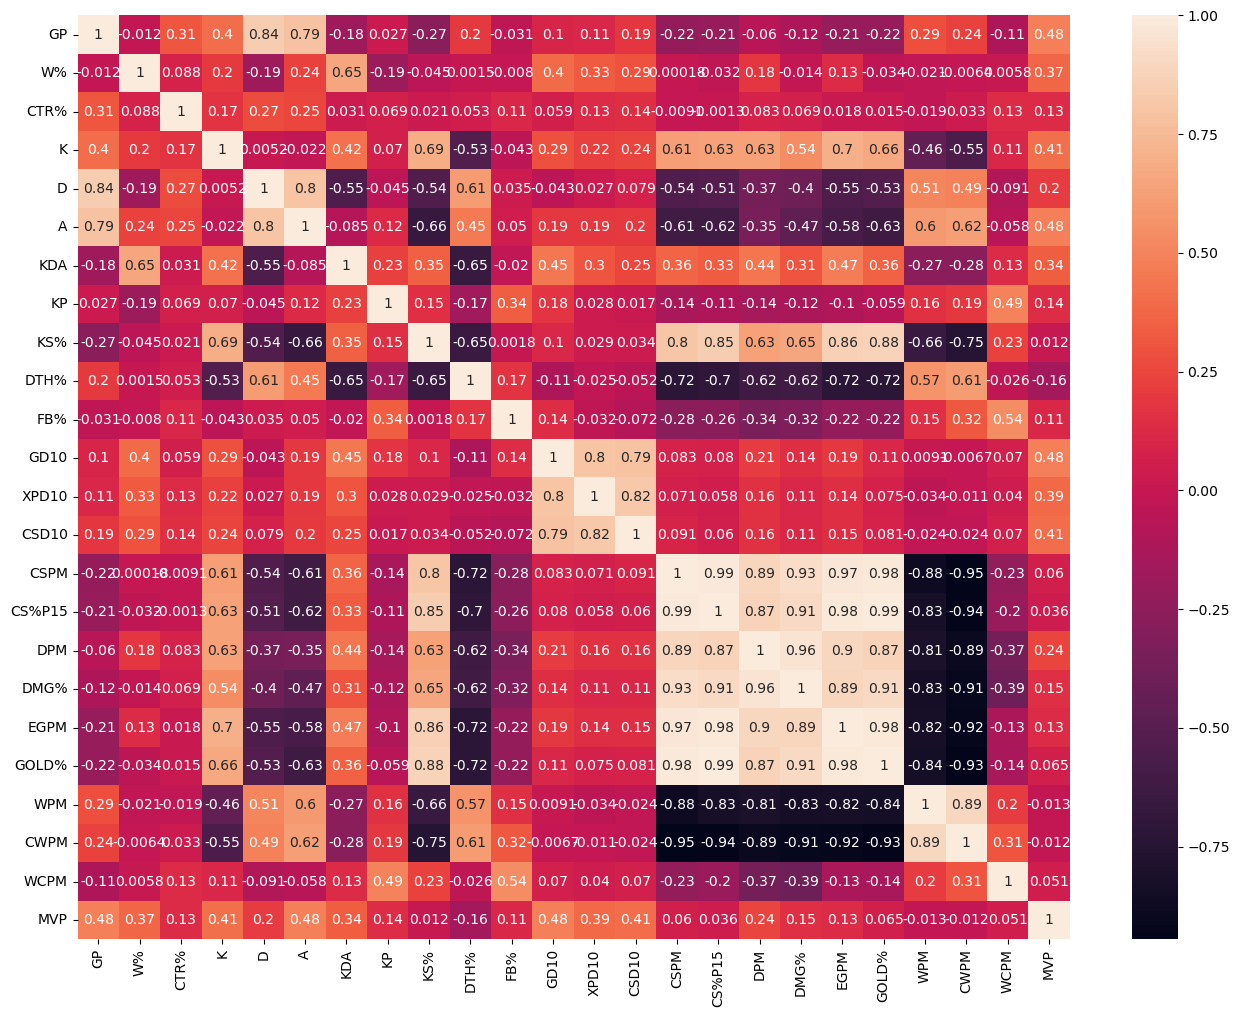

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(whole_set_vals.corr(), annot=True)

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.DataFrame()
vifs['features'] = whole_set_vals.columns
vifs['VIF'] = [variance_inflation_factor(whole_set_vals.values, i)
                          for i in range(len(whole_set_vals.columns))]

In [50]:
print(vifs.sort_values(by='VIF', ascending=False))
# shows us that gold%, egpm, etc are highly dependant on other stats.
# eg. gold% is from higher cspm, higher kills, higher gd@10, etc.

   features          VIF
19    GOLD%  2585.249559
18     EGPM  2036.379370
15   CS%P15  1330.680499
14     CSPM  1199.883063
17     DMG%   372.413577
16      DPM   332.254100
0        GP   274.334222
4         D   203.003913
5         A   184.551748
8       KS%   137.792200
3         K    82.547638
9      DTH%    78.178953
21     CWPM    68.948737
1        W%    68.414251
11     GD10    66.632397
13    CSD10    59.482739
6       KDA    45.932808
12    XPD10    33.373528
20      WPM    29.891488
2      CTR%    23.183018
22     WCPM    18.011241
7        KP    15.933932
23      MVP    10.442634
10      FB%     9.046226


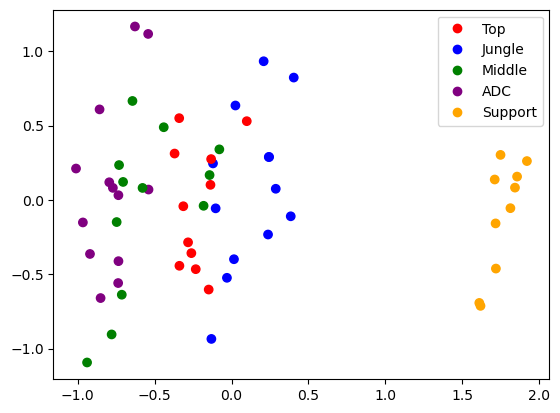

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(whole_set_vals)

label_color_map = {
    'Top': 'red',
    'Jungle': 'blue',
    'Middle': 'green',
    'ADC': 'purple',
    'Support': 'orange'
}

colors = np.array([label_color_map[label] for label in whole_set_labels['Pos']])


fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, 
                     label=larger_dataset_labels['Pos'])

# Add labels to the points
#for i, txt in enumerate(larger_dataset_labels['Pos']):
#    ax.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, 
                              label=label, linestyle='') for label, color in label_color_map.items()]
ax.legend(handles=legend_elements, loc='best')

plt.show()

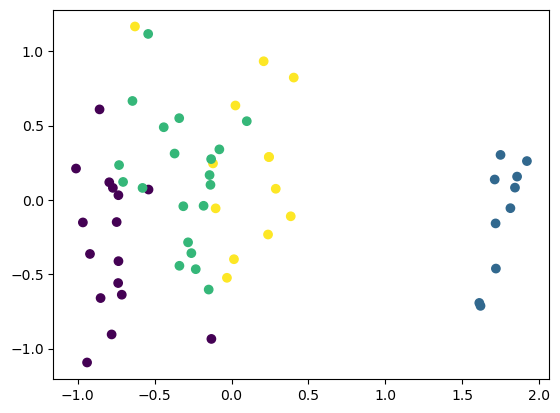

In [70]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels[2], 
                     label=larger_dataset_labels['Pos'])

plt.show()

In [71]:
from sklearn.cluster import SpectralClustering

# Perform PCA with 5 components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(larger_dataset_values)

# Apply spectral clustering to the transformed data
spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42)
spectral_labels = spectral.fit_predict(X_pca)


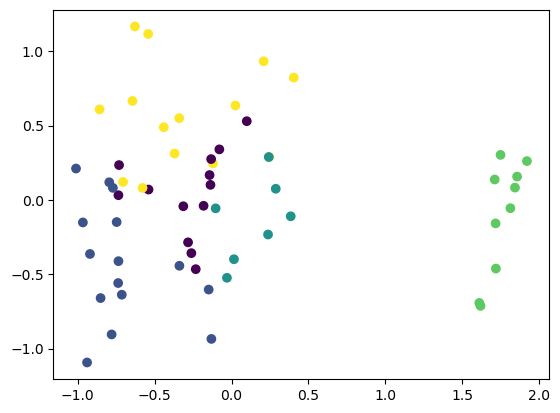

In [72]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels)
plt.show()

In [73]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
pos_encoded = label_encoder.fit_transform(larger_dataset_labels['Pos'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(larger_dataset_values, pos_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%% (with un-PCA\'d features)' % (accuracy * 100.0))


Accuracy: 91.67% (with un-PCA'd features)


In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, pos_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%% (with PCA\'d features)' % (accuracy * 100.0))

Accuracy: 83.33% (with PCA'd features)
